# Batch Normalization Evaluation



* Reference) ndb796/Deep-Learning-Paper-Review-and-Pratice [[link]](https://github.com/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Batch_Normalization_Evaluation_(with_Residual_Connection).ipynb)

## ResNet18 모델 정의 및 인스턴스 초기화

* 일반적인 ResNet18 모델 아키텍처를 사용합니다.
* 배치 정규화(batch normalization) 사용 여부를 설정할 수 있습니다.
* 논문 제목: Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift [[link]](https://arxiv.org/abs/1502.03167)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt


# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, with_BN, stride=1):
        super(BasicBlock, self).__init__()
        self.with_BN = with_BN

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(planes) 

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential() # 단순한 identity mapping인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            modules = [nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False)]
            if with_BN:
                modules.append(nn.BatchNorm2d(planes))
            self.shortcut = nn.Sequential(*modules)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
            out = self.bn2(self.conv2(out))
        else:
            out = F.relu(self.conv1(x))
            out = self.conv2(out)
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, with_BN, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.with_BN = with_BN

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        if with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, with_BN, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, with_BN, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, with_BN, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, with_BN, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, with_BN, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, with_BN, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        if self.with_BN: # 배치 정규화(batch normalization)를 사용하는 경우
            out = F.relu(self.bn1(self.conv1(x)))
        else:
            out = F.relu(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18(with_BN):
    return ResNet(BasicBlock, [2, 2, 2, 2], with_BN)

## 데이터셋(Dataset) 다운로드 및 불러오기

* 실험을 위해 CIFAR-10 데이터셋을 사용합니다.

In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## 학습(Training) 및 테스트(Test) 함수 정의

In [ ]:
criterion = nn.CrossEntropyLoss() # 분류(classification) 문제


def train(net, optimizer, epoch, step):
    net.train()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    steps = [] # 학습 스텝(step)
    losses = [] # 각 스텝에서의 손실(loss)

    for _, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        steps.append(step)
        losses.append(loss.item())
        step += 1

    return correct / total, steps, losses


def test(net, optimizer, epoch):
    net.eval()
    correct = 0 # 정답을 맞힌 이미지 개수
    total = 0 # 전체 이미지 개수
    loss = 0 # 손실(loss)

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.cuda(), targets.cuda()

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

    return correct / total, loss

## Without BN: 학습(Training) 진행

* 먼저 BatchNorm을 적용하지 않은 모델의 성능을 평가합니다.
* 기본적으로 Residual Connection은 Loss Landscape Smoothing 효과가 있다는 점을 감안할 필요가 있습니다.

In [ ]:
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11164362


In [ ]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
    without_BN_train_accuracies.append(train_accuracy)
    without_BN_steps.extend(steps)
    without_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    without_BN_test_accuracies.append(test_accuracy)
    without_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 13.82 / Train loss = 877.4451591968536
Test accuracy = 19.96 / Test loss = 211.33222877979279
[ Epoch: 1/20 ]
Train accuracy = 25.62 / Train loss = 781.9139946699142
Test accuracy = 25.67 / Test loss = 215.59955668449402
[ Epoch: 2/20 ]
Train accuracy = 32.33 / Train loss = 716.7041693925858
Test accuracy = 38.18 / Test loss = 166.62046945095062
[ Epoch: 3/20 ]
Train accuracy = 38.65 / Train loss = 654.1194512844086
Test accuracy = 42.47 / Test loss = 159.25485122203827
[ Epoch: 4/20 ]
Train accuracy = 43.10 / Train loss = 608.4395132064819
Test accuracy = 46.21 / Test loss = 148.01389837265015
[ Epoch: 5/20 ]
Train accuracy = 46.13 / Train loss = 576.4460046291351
Test accuracy = 49.54 / Test loss = 138.55446875095367
[ Epoch: 6/20 ]
Train accuracy = 49.18 / Train loss = 544.6085020303726
Test accuracy = 53.18 / Test loss = 131.1656301021576
[ Epoch: 7/20 ]
Train accuracy = 52.93 / Train loss = 511.26505267620087
Test accuracy = 55.60 / Test loss = 123

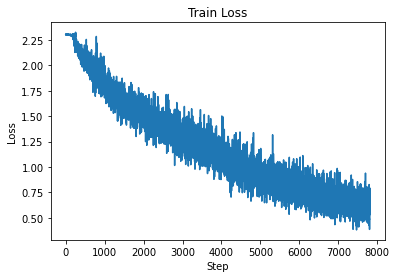

In [ ]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

* 테스트 정확도(accuracy) 및 손실(loss) 값을 시각화합니다.

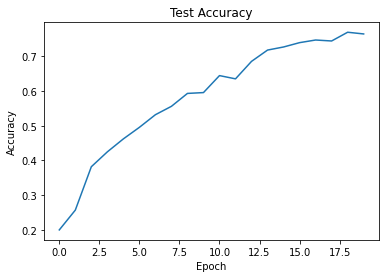

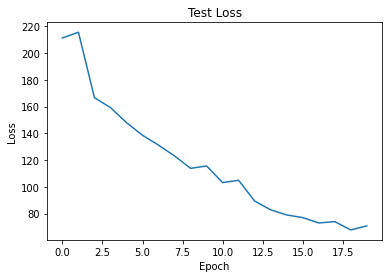

In [ ]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## With BN: 학습(Training) 진행

* 이어서 BatchNorm을 적용했을 때의 성능을 평가합니다.

In [ ]:
print('모델 파라미터를 초기화합니다.')
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('학습 가능한 총 파라미터 수:', total_params)

모델 파라미터를 초기화합니다.
학습 가능한 총 파라미터 수: 11173962


In [ ]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
    print(f'[ Epoch: {epoch}/{epochs} ]')
    train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
    with_BN_train_accuracies.append(train_accuracy)
    with_BN_steps.extend(steps)
    with_BN_train_losses.extend(train_losses)
    print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

    test_accuracy, test_loss = test(net, optimizer, epoch)
    with_BN_test_accuracies.append(test_accuracy)
    with_BN_test_losses.append(test_loss)
    print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 46.15 / Train loss = 574.6796599030495
Test accuracy = 52.92 / Test loss = 143.56228506565094
[ Epoch: 1/20 ]
Train accuracy = 66.17 / Train loss = 374.85369062423706
Test accuracy = 62.53 / Test loss = 115.81821936368942
[ Epoch: 2/20 ]
Train accuracy = 74.61 / Train loss = 284.72682443261147
Test accuracy = 70.68 / Test loss = 88.61280828714371
[ Epoch: 3/20 ]
Train accuracy = 78.62 / Train loss = 240.25227046012878
Test accuracy = 79.79 / Test loss = 60.41055393218994
[ Epoch: 4/20 ]
Train accuracy = 81.75 / Train loss = 204.66042411327362
Test accuracy = 74.35 / Test loss = 76.69614398479462
[ Epoch: 5/20 ]
Train accuracy = 83.69 / Train loss = 183.86776423454285
Test accuracy = 82.47 / Test loss = 52.931159287691116
[ Epoch: 6/20 ]
Train accuracy = 85.25 / Train loss = 165.38686895370483
Test accuracy = 81.13 / Test loss = 55.13340915739536
[ Epoch: 7/20 ]
Train accuracy = 86.88 / Train loss = 148.98560489714146
Test accuracy = 79.34 / Test loss = 

* 학습 과정에서의 스텝(step)에 따른 손실(loss) 값을 시각화합니다.

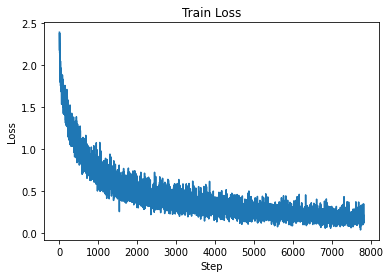

In [ ]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

* 테스트 정확도(accuracy) 및 손실(loss) 값을 시각화합니다.

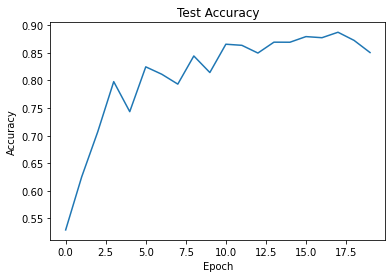

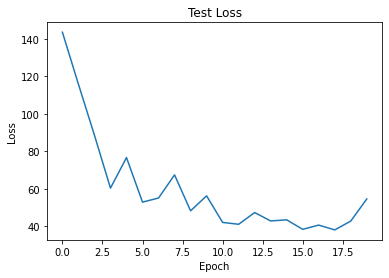

In [ ]:
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Without BN과 With BN 비교하기

* 배치 정규화(batch normalization)를 이용할 때 손실 값의 변동 폭이 작습니다.
* 성능이 훨씬 좋아지는 것을 확인할 수 있으며 초반에도 빠른 성능 향상을 보입니다.

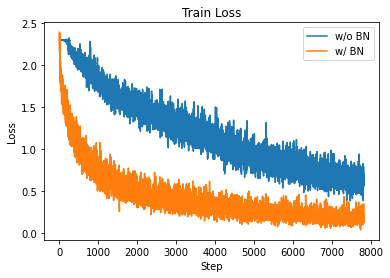

In [ ]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

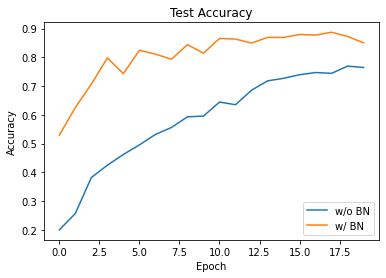

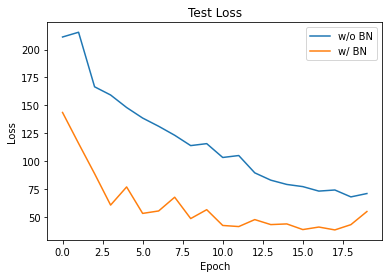

In [ ]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()